# Import Statements

In [1]:
import numpy as np
import networkx as nx
import math
import time
from scipy.interpolate import UnivariateSpline
import osmnx as ox
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import transform

# Functions to Build Real-world Graph

In [2]:
MOORE_AFTER_BREAK_SPLINE = UnivariateSpline(
    [20, 30, 40, 50, 60, 70, 80, 90, 100],
    [3.9, 6, 11, 18, 27, 39, 54, 58, 84],
)
MOORE_BEFORE_BREAK_SPLINE = UnivariateSpline(
    [20, 30, 40, 50, 60, 70, 80, 90, 100],
    [6, 8, 11, 14, 17, 19, 22, 25, 28],
)

MOORE_SAFE_BREAKING_DISTANCE = lambda x: MOORE_AFTER_BREAK_SPLINE(
    x
) + MOORE_BEFORE_BREAK_SPLINE(x)

def moore(lanes: float, max_speed: float):
    return 1000 * max_speed / MOORE_SAFE_BREAKING_DISTANCE(max_speed) * lanes

def add_capacities(G, method=moore):

    G = G.copy()
    cap = []
    
    for u, v, i in G.edges:
        edge_data = G.get_edge_data(u, v, i)
        raw_lanes = edge_data.get("lanes")
        
        if raw_lanes is None:
            lanes = 1
            
        elif isinstance(raw_lanes, str):
            lanes = int(raw_lanes) / 2  
            
        elif isinstance(raw_lanes, list):
            lanes = sum(int(x) for x in raw_lanes) / 2
            
        G[u][v][i]["upper"] = int(method(lanes, edge_data["speed_kph"]))
    return G

In [3]:
###don't need for max flow/quickest flow
def add_costs(G, costs:[int, np.ndarray] = 0):
    if type(costs) == int:
        for u,v,i in G.edges:
            G[u][v][i]['cost'] = costs
    else:
        count = 0
        for u,v,i in G.edges:
            G[u][v][i]['cost'] = costs[count]
    return G

In [4]:
def add_orig_dest(G, sup_dem:[int, np.ndarray]):
    if type(sup_dem) == int:
        for i in G.nodes:
            G._node[i]['sup_dem'] = sup_dem
    else:
        for i in G.nodes:
            G._node[i]['sup_dem'] = sup_dem[i]
    return G

# Functions to set up for Max Flow Alogirthm

In [5]:
def add_s_t(G, ten, time_horizon,removed_nodes_mat):
    orig_nodes = list(G.nodes)
    ten_nodes = list(ten.nodes)

    sup_nodes = [x for x,y in G.nodes(data=True) if y['sup_dem'] > 0]
    dem_nodes = [x for x,y in G.nodes(data=True) if y['sup_dem'] < 0]
    
    s = 0
    t = max(ten_nodes)+1
    
    ten.add_node(s,name = f'{s}-{0}',level = 0)
    ten.add_node(t,name = f'{len(orig_nodes)}-{time_horizon-1}',level = time_horizon-1)
    
    for i in range(len(orig_nodes)):
        if i in sup_nodes:
            ten.add_edge(s, i+1, cost = 0, upper = G._node[i]['sup_dem'], lower = 0)
        elif i in dem_nodes:
            ###need to add in check for last time interval node is still available
            for k in range(time_horizon-1):
                added = False
                if i in removed_nodes_mat[k+1]:
                    print((i+1) + ((k) * len(orig_nodes)))
                    ten.add_edge((i+1) + ((k) * len(orig_nodes)),t, cost = 0, upper = -G._node[i]['sup_dem'], lower = 0)
                    added = True
                    break;
            if added is False:
                ten.add_edge((i+1) + ((time_horizon-1) * len(orig_nodes)),t, cost = 0, upper = -G._node[i]['sup_dem'], lower = 0)
    return ten

In [93]:
###note that this function does not account for the cost of each edge, just the capacity
def simplify_multigraph(graph):
    num_nodes = max(graph.nodes)
    edges = graph.edges
    
    simp_graph = nx.DiGraph()
    simp_graph.add_nodes_from(graph.nodes(data=True))
    
    for i in range(num_nodes+1):
        for j in range(num_nodes+1):
            if (i,j) in edges:
                num_edges = graph.number_of_edges(i,j)
                tot_cap = graph[i][j][num_edges-1]['upper']
                if num_edges > 1:
                    for k in range(1,num_edges):
                        tot_cap = tot_cap + graph[i][j][k]['upper']
                simp_graph.add_edge(i,j, upper = tot_cap, lower = 0)
            
    return simp_graph

In [99]:
def color_max_flow(graph, flow_dict):
    num_nodes = max(graph.nodes)+1
    edges = graph.edges
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if (i,j) in edges:
                graph[i][j]['color'] = (0,0,0)
                if flow_dict[i][j] != 0:
                    graph[i][j]['color'] = (1,0,0)
                    
    return graph

# Functions to Include Fire Data with Graph

In [8]:
def geodesic_point_buffer(graph,lat, lon, radius):
    """
    Creates circles from given latitude, longitude, and radius
    :param lat: latitude from original data
    :param lon: longitude from original data
    :param radius: radius from original data
    """
    # Azimuthal equidistant projection
    aeqd_proj = CRS.from_proj4(f"+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0")
    tfmr = Transformer.from_proj(aeqd_proj, aeqd_proj.geodetic_crs)
    buf = Point(0, 0).buffer(radius * 1609.34)  # distance in miles (converts from meters to miles)
    circle = Polygon(transform(tfmr.transform, buf).exterior.coords[:])
    net_trans = Transformer.from_crs(aeqd_proj.geodetic_crs, graph.graph['crs'])
    proj_circ = Polygon(transform(net_trans.transform,circle).exterior.coords[:])
    
    return proj_circ

In [9]:
def det_rem_parts(G, fire_polygon, smoke_polygon):
    ###find nodes inside poly to remove
    start_gs = time.process_time()
    gs_nodes = ox.utils_graph.graph_to_gdfs(G,nodes = True,edges = False, node_geometry = True)[['geometry']]
    gs_edges = ox.utils_graph.graph_to_gdfs(G,nodes = False, edges = True)[['geometry']]
    end_gs = time.process_time()
    # print ("Time elapsed for gs: ", end_gs - start_gs)

    nodes_to_remove = []
    edges_to_remove = []
    start_to_remove = time.process_time()
    for point in gs_nodes['geometry']:
        ###currently this takes a long time to run, but a smaller polygon might make this run faster
        if point.intersects(smoke_polygon):
            node = ox.distance.nearest_nodes(G,point.x,point.y,return_dist=False)
            nodes_to_remove.append(node)
    for i in range(len(gs_edges)):
        entry =  gs_edges.iloc[i]
        if entry['geometry'].intersects(fire_polygon):
            entry = gs_edges.iloc[[i]]
            edges_to_remove.append(entry['geometry'].index[0])
    end_to_remove = time.process_time()
    # print ("Time elapsed for create remove list: ", end_to_remove - start_to_remove)

    return (nodes_to_remove, edges_to_remove)

In [102]:
def create_fire_mat(G, fire_origin, init_radius, time_horizon):
    removed_node_mat = []
    removed_edge_mat = []
    for i in range(time_horizon):
        ###create fire_poly and smoke_poly in coordinate system of network
        radius = init_radius+(0.025*i) #increase the radius by 0.025 of a meter with each time step
        # radius = init_radius #increase the radius by a quarter meter with each time step
        fire_polygon = geodesic_point_buffer(G,fire_origin[0],fire_origin[1],radius)
        smoke_polygon = geodesic_point_buffer(G,fire_origin[0],fire_origin[1],radius*1.01)
                                              
        removed_nodes,removed_edges = det_rem_parts(G, fire_polygon, smoke_polygon)

        removed_node_mat.append(removed_nodes)
        removed_edge_mat.append(removed_edges)
    return (removed_node_mat, removed_edge_mat)

# Create TEN (accounts for removed nodes and arcs)

In [11]:
def time_expand_with_removal(G, time_int_size, time_horizon,fire_origin, init_radius):
    start = time.time()
    orig_nodes = list(G.nodes)
    orig_edges = list(G.edges)
    ten = nx.MultiDiGraph()

    removed_nodes_mat,removed_edges_mat = create_fire_mat(G, fire_origin, init_radius, time_horizon)

    ###add in all nodes for time-expanded network
    node_num = 1
    for j in range(time_horizon):
        for i in range(len(orig_nodes)):
            #check not one of nodes that have been removed during that time interval
            if i not in removed_nodes_mat[j]:
                if j == 0:
                    node_name = f'{i+1}-{j}'
                    ten.add_node(node_num, name = node_name, level = j, sup_dem = G._node[i]['sup_dem'])
                    # node_num += 1
                else:
                    node_name = f'{i+1}-{j}'
                    ten.add_node(node_num, name = node_name, level = j, sup_dem = 0)
            node_num += 1
                
            
    ###add in hold over arcs for supply/demand nodes
    for i in range(len(orig_nodes)):
        if G._node[i]['sup_dem'] >  0:
            for j in range(time_horizon-1):
                if i not in removed_nodes_mat[j+1]:
                    ten.add_edge((i+1)+(len(orig_nodes)*j),(i+1)+(len(orig_nodes)*(j+1)),cost = 0, upper =  G._node[i]['sup_dem'] , lower = 0)
        elif G._node[i]['sup_dem'] <  0:
            for j in range(time_horizon-1):
                if i not in removed_nodes_mat[j+1]:
                    ten.add_edge((i+1)+(len(orig_nodes)*j),(i+1)+(len(orig_nodes)*(j+1)),cost = 0, upper =  -G._node[i]['sup_dem'] , lower = 0 )
    
    ###in the case of a multidigraph
    if G.is_multigraph():
        node_num = 0
        for j in range(time_horizon-1):
            for i in range(len(orig_nodes)):
                ###keep track of node number for the overall network (need to account for nodes in the expansions)
                node_num +=1
                if i not in removed_nodes_mat[j]:
                    for k in range(len(orig_nodes)):
                        for m in range(G.number_of_edges(i,k)+1):
                            ###check if edge exists in graph
                            if (i,k,m) in orig_edges and (i,k,m) not in removed_edges_mat[j]:
                                ###deteremine how many time intervals it will cross
                                time_int_end = math.ceil(G[i][k][m]['travel_time']/time_int_size)
                                ###check if the number it crosses exist in the network
                                if time_int_end+j< time_horizon:
                                    ###check that end node exists during that time interval
                                    if k not in removed_nodes_mat[time_int_end+j]:
                                        ####add edge to time-expanded network
                                        ten.add_edge(node_num,(node_num)+(k-i)+(len(orig_nodes)*time_int_end),cost = G[i][k][m]['cost'] ,upper = G[i][k][m]['upper'], lower = 0)
                            
    ##in the case of a digraph that is not a multdigraph
    elif G.is_directed():
        node_num = 0
        for j in range(time_horizon-1):
            for i in range(len(orig_nodes)):
                ###keep track of node number for the overall network (need to account for nodes in the expansions)
                node_num +=1
                if i not in removed_nodes_mat[j]:
                    for k in range(len(orig_nodes)):
                        ###check if edge exists in graph
                        if (i,k) in orig_edges and (i,k) not in removed_edges_mat[j]:
                            ###deteremine how many time intervals it will cross
                            time_int_end = math.ceil(G[i][k]['travel_time']/time_int_size)
                            ###check if the number it crosses exist in the network
                            if time_int_end+j< time_horizon:
                                ###check that end node exists during that time interval
                                if k not in removed_nodes_mat[time_int_end+j]:
                                    ####add edge to time-expanded network
                                     ten.add_edge(node_num,(node_num)+(k-i)+(len(orig_nodes)*time_int_end),cost = G[i][k]['cost'] ,upper = G[i][k]['upper'], lower = 0)
    else:
        raise Exception("Must Input a DiGraph or MultiDiGraph")


    ###Remove isolated nodes in TEN
    ten.remove_nodes_from(list(nx.isolates(ten)))
    
    end = time.time()
    ###used for checking how long larger networks/expansions take to construct
    if end-start > 1:
        print('Number of Time Intervals:', time_horizon)
        print('Build Time: ',end-start, ' seconds')

    return (ten, removed_nodes_mat, removed_edges_mat)

# Determine number of Time Intervals to Evacuate People

In [73]:
def det_num_int(G, pop, fire_orgin, init_radius):
    flow_value = 0

    time_int_len = 1
    num_time_ints = 1 ###time zero is when num_time_ints = 1

    while flow_value < pop:
    # while num_time_ints < 3:
        ten = nx.MultiDiGraph()
        simp_tem = nx.DiGraph()
        max_flow_ten = nx.DiGraph()
        num_time_ints +=1
        
        ten, removed_nodes_mat, removed_edges_mat = time_expand_with_removal(G, time_int_len, num_time_ints, fire_origin, init_radius)
        simp_ten = simplify_multigraph(ten)
        max_flow_ten = add_s_t(G, simp_ten, num_time_ints, removed_nodes_mat)
        flow_value, flow_dict = nx.maximum_flow(max_flow_ten, 0, max(list(max_flow_ten.nodes)),capacity = 'upper')
        
    
    colored_max_flow_ten = color_max_flow(max_flow_ten,flow_dict)
    num_nodes = max(list(colored_max_flow_ten))
    pos = nx.multipartite_layout(simp_ten, subset_key="level")
    pos[0]= np.array([pos[1][0]-0.05,pos[1][1]])
    pos[max(list(simp_ten.nodes))] = np.array([pos[max(list(simp_ten.nodes))-1][0]+0.05,pos[max(list(simp_ten.nodes))-1][1]])
    colors = [colored_max_flow_ten[u][v]['color'] for u,v in colored_max_flow_ten.edges]
    nx.draw(colored_max_flow_ten, pos, edge_color=colors,with_labels = True)
    
    return (num_time_ints, flow_value, colored_max_flow_ten) 

# Build Real-world Graph

In [26]:
start = time.time()
#import data from osmnx, can input any city, state, etc.
G = ox.project_graph(ox.graph_from_place('Lyons Colorado', network_type='drive'))
print('Importing Network Complete')

#get rid of intersections that are not actually intersections
G = ox.simplification.consolidate_intersections(G, tolerance=10, rebuild_graph=True, dead_ends=True, reconnect_edges = True)
print('Consolidation Complete')

#add edge speeds
G = ox.speed.add_edge_speeds(G)
print('Speed Added')

#add travel times
G = ox.speed.add_edge_travel_times(G)
print('Travel Time Added')

#add capacities (computed using moore method)
G = add_capacities(G)
print('Capacities Added')

###only need if doing something with min-cost
costs = 0
G = add_costs(G,costs)
print('Costs Added')

#sup_dem:int = 0
sup_dem = np.zeros(len(G.nodes))
sup_dem[0] = 20
sup_dem[len(G.nodes)-1] = -20
G = add_orig_dest(G,sup_dem)
print('Supply and Demand Values Added')

# ###remove self-loops
# G = G.remove_edges_from(list(nx.selfloop_edges(G)))
# print('Self-loops Removed')

end = time.time()

print('Time to Build Original Network: ',end-start, ' seconds')

Importing Network Complete
Consolidation Complete
Speed Added
Travel Time Added
Capacities Added
Costs Added
Supply and Demand Values Added
Time to Build Original Network:  0.43326687812805176  seconds


# Code for Build Testing

Number of Time Intervals: 12
Build Time:  1.0618245601654053  seconds
Number of Time Intervals: 13
Build Time:  1.1796658039093018  seconds
Number of Time Intervals: 14
Build Time:  1.3205854892730713  seconds
Number of Time Intervals: 15
Build Time:  1.459062099456787  seconds
Number of Time Intervals: 16
Build Time:  1.5968527793884277  seconds
Number of Time Intervals: 17
Build Time:  1.7500619888305664  seconds
Number of Time Intervals: 18
Build Time:  1.9212892055511475  seconds
Number of Time Intervals: 19
Build Time:  2.1192963123321533  seconds
Number of Time Intervals: 20
Build Time:  2.2951407432556152  seconds
Number of Time Intervals: 21
Build Time:  2.5101165771484375  seconds
Number of Time Intervals: 21
Flow Value: 20.0


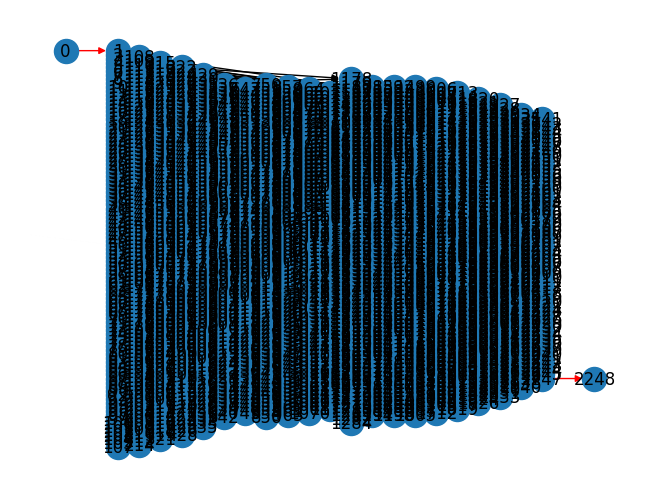

In [104]:
fire_origin = [40.229520, -105.263912]
lyons = G.copy()
fire_radius =  0.004

num_time_ints, max_flow, G_test = det_num_int(lyons, 4, fire_origin, fire_radius)
print('Number of Time Intervals:',num_time_ints)
print('Flow Value:', max_flow)